## Keypoint Detection Layer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import leap
from leap.datasets.physics_dataset import PhysicsDatasetTwoSample
import torchvision.transforms as transforms
from leap.modules.components.base import Namespace
from leap.tools.utils import load_yaml
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from torch.utils.data import DataLoader, random_split
from leap.modules.srnn_kp import SRNNKeypointNS
from leap.modules.keypointer import Keypointer

In [5]:
import torch
import numpy as np
import seaborn as sns

In [6]:
import ipdb as pdb

In [7]:
kp = Keypointer.load_from_checkpoint('/srv/data/ltcl/log/weiran/kp_5_ball/lightning_logs/version_3/checkpoints/epoch=9-step=366890.ckpt',
                                      n_kps=5, lim=[-1., 1., -1., 1.])

In [8]:
torch.save(kp.kp.keypoint_predictor.model.state_dict(), '/srv/data/ltcl/ckpts/keypoint_predictor.pth')

In [9]:
cfg = load_yaml('../ltcl/configs/ball_5_s1.yaml')
hparams = Namespace()
for k in cfg:
    setattr(hparams, k, cfg[k])
trans_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
dataset = PhysicsDatasetTwoSample(hparams, trans_to_tensor=trans_to_tensor)

In [11]:
dataset.load_img = True

In [12]:
dataset.dt = 0

In [16]:
batch_size=128
length=6

In [17]:
data = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [18]:
batch = next(iter(data))

In [11]:
x, y = batch['s1']['xt'], batch['s1']['yt']
batch_size, length, nc, h, w = x.shape
x_flat = x.view(-1, nc, h, w)
x_mask = ((x_flat[:,0]!=0) + (x_flat[:,1]!=0) + (x_flat[:,2]!=0)).float().view(batch_size, length, 1, h, w)

(-0.5, 63.5, 63.5, -0.5)

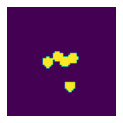

In [20]:
fig = plt.figure(figsize=(2,2))
plt.imshow(x_mask[3,0,0])
plt.axis('off')

In [13]:
model = SRNNKeypointNS.load_from_checkpoint('/srv/data/ltcl/log/weiran/mbi_2lag/lightning_logs/version_2/checkpoints/epoch=0-step=10880.ckpt',
                                                  nc=3, length=4, n_kps=5, z_dim=2, lag=2, nclass=50, hidden_dim=8, 
                                            kp_pth='/srv/data/ltcl/log/weiran/kp_5_ball/lightning_logs/version_3/checkpoints/epoch=9-step=366890.ckpt')

In [14]:
feat, kpts, hmap = model.kp.forward(batch['s1']['xt'])
# zs: [B, length, n_kps*2]
zs, mus, logvars = model.inference(kpts)
kpts = zs[...,:5*2].reshape(batch_size, length, 5, 2)
x_recon = model.kp.reconstruct(kpts, feat)

In [147]:
feat, kpts, hmap = kp.forward(batch['s1']['xt'])

In [150]:
latent_size = 10
A = kpts[:,1,:,:].detach().reshape(-1,10)#mus.reshape(-1,10).detach().cpu().numpy()
B = batch['s1']['yt'][:,1,:,:2].reshape(-1,10).detach().cpu().numpy()
C = np.zeros((latent_size,latent_size))
for i in range(latent_size):
    C[i] = -np.abs(np.corrcoef(B, A, rowvar=False)[i,latent_size:])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
A = A[:, col_ind]
mask = np.ones(latent_size)
for i in range(latent_size):
    if np.corrcoef(B, A, rowvar=False)[i,latent_size:][i] > 0:
        mask[i] = -1
print("Permutation:",col_ind)
print("Sign Flip:", mask)

Permutation: [2 3 8 9 0 1 4 5 6 7]
Sign Flip: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


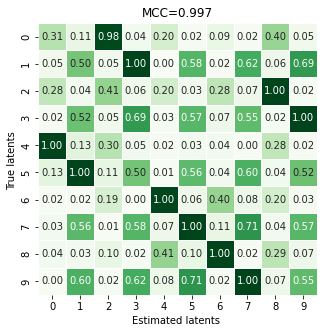

In [152]:
with PdfPages(figure_path + '/ball_mcc.pdf') as pdf:

    fig = plt.figure(figsize=(5,5))
    sns.heatmap(-C, vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
    plt.xlabel("Estimated latents ") 
    plt.ylabel("True latents ") 
    plt.title("MCC=%.3f"%np.abs(C[row_ind, col_ind]).mean());
    pdf.savefig(fig, bbox_inches="tight")

In [25]:
X1 = batch['s1']['yt'][:,0,:,:2].numpy()
X2 = batch['s1']['yt'][:,1,:,:2].numpy()
X3 = batch['s1']['yt'][:,2,:,:2].numpy()
A1 = batch['s1']['actions'][:,0,:,:2].numpy()
A2 = batch['s1']['actions'][:,1,:,:2].numpy()
A3 = batch['s1']['actions'][:,2,:,:2].numpy()

(array([1.0000e+01, 4.2000e+01, 4.2400e+02, 4.5520e+03, 1.0063e+04,
        8.0690e+03, 2.2560e+03, 1.5100e+02, 2.8000e+01, 5.0000e+00]),
 array([-2.7043815 , -2.1405752 , -1.5767689 , -1.0129626 , -0.44915628,
         0.11465001,  0.6784563 ,  1.2422626 ,  1.8060689 ,  2.3698752 ,
         2.9336815 ], dtype=float32),
 <BarContainer object of 10 artists>)

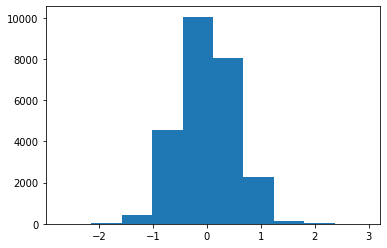

In [26]:
plt.hist(X2.reshape(batch_size, -1)[:,2])

In [382]:
A1.min()*600

-999.9999761581421

In [61]:
X = np.concatenate((X2.reshape(batch_size,-1), X1.reshape(batch_size,-1)),axis=-1)


In [90]:
out = [ ]
for i in range(10):
    y = X3.reshape(batch_size,-1)[:,i]
    clf = Lasso(alpha=0.0001, normalize=True, max_iter=5000).fit(X, y)
    coef = clf.coef_.reshape(2,5,2)
    coef = np.concatenate((coef[0], coef[1]), axis=1)[:,[0,2,1,3]]
    coef = coef.reshape(-1)
    out.append(coef)

In [93]:
out = np.stack(out)

In [62]:
from sklearn.linear_model import Lasso, LassoCV


In [122]:
figure_path = '/home/weiran/figs/'
from matplotlib.backends.backend_pdf import PdfPages

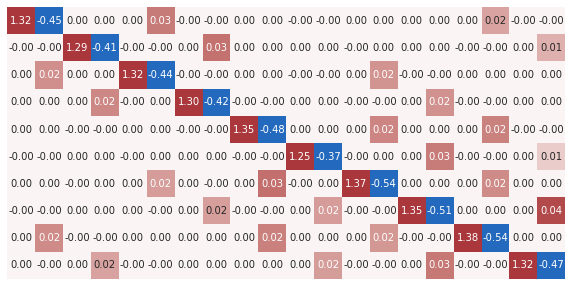

In [123]:
with PdfPages(figure_path + '/B1_ball.pdf') as pdf:
    fig = plt.figure(figsize=(10,5))
    sns.heatmap(out, cmap='vlag', vmin=-0.04, vmax=0.04, annot=True, fmt='.2f', cbar=False)
    plt.axis('off')
    pdf.savefig(fig, bbox_inches="tight")

In [37]:
batch['s1']['graph_gt'][1][0]

tensor([[[0.0000],
         [0.7720],
         [0.0000],
         [0.0000],
         [8.6539]],

        [[0.7720],
         [0.0000],
         [0.0000],
         [4.9685],
         [0.0000]],

        [[0.0000],
         [0.0000],
         [0.0000],
         [1.1909],
         [6.0713]],

        [[0.0000],
         [4.9685],
         [1.1909],
         [0.0000],
         [5.9493]],

        [[8.6539],
         [0.0000],
         [6.0713],
         [5.9493],
         [0.0000]]])

In [30]:
clf.score(X,y)

0.9967969725302102

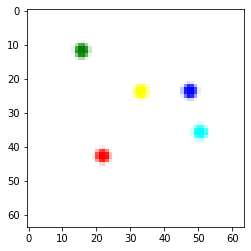

In [326]:
plt.imshow(batch['s1']['xt'][0,0].permute(1,2,0))

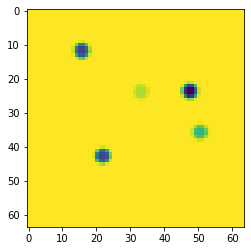

In [322]:
plt.imshow(torchvision.transforms.Grayscale()(batch['s1']['xt'])[0,0].permute(1,2,0))

In [172]:
clf.score(X,y)

0.9866479001217311

In [218]:
mask = batch['s1']['graph_gt'][1][0].squeeze() > 0
mask = mask.fill_diagonal_(True)

In [234]:
mask[1, 3] = False
mask[4, 2] = False

<AxesSubplot:>

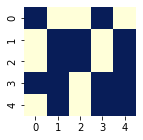

In [235]:
fig = plt.figure(figsize=(2,2))
sns.heatmap(mask, cmap="YlGnBu", cbar=False)

<AxesSubplot:>

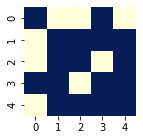

In [219]:
fig = plt.figure(figsize=(2,2))
sns.heatmap(mask, cmap="YlGnBu", cbar=False)

In [209]:
batch['s1']['graph_gt'][1][0].squeeze() > 0

tensor([[False, False, False,  True, False],
        [False, False,  True,  True,  True],
        [False,  True, False, False,  True],
        [ True,  True, False, False,  True],
        [False,  True,  True,  True, False]])

In [56]:
clf.score(X, y)

0.9976415870578089

In [17]:
2, 4, 5

(2, 4, 5)

In [18]:
zs_perm = torch.tensor(A.reshape(batch_size, length, -1))

In [19]:
from torch.autograd.functional import jacobian

In [20]:
batch['s1']['graph_gt'][1][10].squeeze()

tensor([[  0.0000,   0.0000,   0.0000,  54.0833,   0.0000],
        [  0.0000,   0.0000,  22.3903,  87.4525,  47.6481],
        [  0.0000,  22.3903,   0.0000,   0.0000, 114.7666],
        [ 54.0833,  87.4525,   0.0000,   0.0000,  34.9792],
        [  0.0000,  47.6481, 114.7666,  34.9792,   0.0000]])

In [28]:
def compute_masked_jacobian(x, masks, gs, L):
    def masked_forward(mask, xxi, yy):
        inputs = torch.cat((yy*mask, xxi),dim=-1)
        return gs[i](inputs)
    batch_size, length, input_dim = x.shape
    x = x.unfold(dimension = 1, size = L+1, step = 1)
    x = torch.swapaxes(x, 2, 3)
    shape = x.shape
    x = x.reshape(-1, L+1, input_dim)
    xx, yy = x[:,-1:], x[:,:-1]
    yy = yy.reshape(-1, L*input_dim)
    pdds = [ ]
    for i in range(input_dim):
#         xxi = xx[:,:,i]
        mask = masks[i]
        # Redefine input function
        inputs = torch.cat((yy*mask, xx[:,:,i]),dim=-1)
        residual = gs[i](inputs)
        with torch.enable_grad():
            pdd = jacobian(gs[i], inputs, create_graph=True, vectorize=True)
#             pdd = jacobian(masked_forward, (mask, xxi, yy), create_graph=True, vectorize=True)
            pdb.set_trace()
            pdds.append(pdd[2])
    return torch.stack(pdds, 0).squeeze()

In [34]:
pdds = compute_masked_jacobian(mus.detach(), torch.sigmoid(model.logits).detach(), model.transition_prior.gs, 2)

> /tmp/ipykernel_30513/330634037.py(23)compute_masked_jacobian()
     22             pdb.set_trace()
---> 23             pdds.append(pdd[2])
     24     return torch.stack(pdds, 0).squeeze()

ipdb> q


BdbQuit: 

In [345]:
pdds[0,0,0,:].reshape(2,10) == pdds[0,2,2,:].reshape(2,10)

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

In [33]:
model.transition_prior(mus, torch.sigmoid(model.logits).detach())

> /home/weiran/project/ltcl/ltcl/modules/components/transition.py(151)forward()
    150                 pdb.set_trace()
--> 151                 inputs = torch.cat((yy*mask, xx[:,:,i]),dim=-1)
    152             residual = self.gs[i](inputs)

ipdb> c
> /home/weiran/project/ltcl/ltcl/modules/components/transition.py(157)forward()
    156             pdb.set_trace()
--> 157             logabsdet = torch.log(torch.abs(torch.diag(pdd[:,0,:,-1])))
    158             sum_log_abs_det_jacobian += logabsdet

ipdb> residuals
[]
ipdb> residual
tensor([[ 1.6637e-01],
        [ 6.6921e-01],
        [ 2.8552e-02],
        [ 6.3329e-01],
        [ 1.1346e-02],
        [-1.0987e-01],
        [-3.7489e-01],
        [-4.2310e-01],
        [ 1.3645e-01],
        [ 8.5296e-02],
        [ 1.6670e-02],
        [ 2.6937e-02],
        [-2.4581e-01],
        [-2.0924e-01],
        [-5.1823e-01],
        [-2.4189e-01],
        [ 4.5802e-01],
        [ 3.3404e-02],
        [ 2.8210e-01],
        [ 1.8099e-01],


ipdb> torch.diag(pdd[:,0,:,-1])
tensor([-11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998,
        -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998,
        -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998,
        -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998,
        -11.1998, -11.1998, -11.1998, -11.1998, -11.1642, -11.1998, -11.1998,
        -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998,
        -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1642,
        -11.1642, -11.1642, -11.1642, -11.1998, -11.1998, -11.1998, -11.1998,
        -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998,
        -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998,
        -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998,
        -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998, -11.1998,
        -11.1998, -11.1998, -11.

ipdb> torch.diag(pdd[:,0,:,3])
tensor([0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844,
        0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844,
        0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844,
        0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.1933, 0.2844, 0.2844, 0.2844,
        0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844,
        0.2844, 0.2844, 0.2844, 0.1933, 0.1933, 0.1933, 0.1933, 0.2844, 0.2844,
        0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844,
        0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844,
        0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844,
        0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844,
        0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.1933, 0.1933, 0.1933,
        0.1933, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844, 0.2844,
        0

ipdb> torch.diag(pdd[:,0,:,5])
tensor([-0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681,
        -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681,
        -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681,
        -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681,
        -0.1990, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681,
        -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681,
        -0.1990, -0.1990, -0.1990, -0.1990, -0.1681, -0.1681, -0.1681, -0.1681,
        -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681,
        -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681,
        -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681,
        -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681,
        -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681, -0.1681,
        -

ipdb> torch.diag(pdd[:,0,:,7])
tensor([0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077,
        0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077,
        0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077,
        0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1642, 0.1077, 0.1077, 0.1077,
        0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077,
        0.1077, 0.1077, 0.1077, 0.1642, 0.1642, 0.1642, 0.1642, 0.1077, 0.1077,
        0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077,
        0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077,
        0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077,
        0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077,
        0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1642, 0.1642, 0.1642,
        0.1642, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077, 0.1077,
        0

ipdb> torch.diag(pdd[:,0,:,9])
tensor([-0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076,
        -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076,
        -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076,
        -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076,
        -0.0195, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076,
        -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076,
        -0.0195, -0.0195, -0.0195, -0.0195, -0.0076, -0.0076, -0.0076, -0.0076,
        -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076,
        -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076,
        -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076,
        -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076,
        -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076, -0.0076,
        -

ipdb> torch.diag(pdd[:,0,:,11])
tensor([-0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731,
        -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731,
        -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731,
        -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731,
        -0.2804, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731,
        -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731,
        -0.2804, -0.2804, -0.2804, -0.2804, -0.1731, -0.1731, -0.1731, -0.1731,
        -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731,
        -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731,
        -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731,
        -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731,
        -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731, -0.1731,
        

ipdb> q


BdbQuit: 

In [288]:
out = [ ]
for b_idx in range(batch_size*(length-2)):
    out.append(pdds[:, b_idx,b_idx,:])
out = torch.stack(out,0)

In [290]:
out.abs().mean(0)[1].reshape(2,10)

tensor([[1.3403e-02, 2.8122e+00, 7.8797e-03, 2.0579e-02, 3.9219e-03, 2.2814e-01,
         1.0765e-03, 1.0668e-01, 9.6951e-03, 8.7248e-01],
        [1.2821e-02, 1.4018e+01, 1.9967e-03, 3.4346e-02, 4.6324e-03, 2.5565e-01,
         6.9925e-03, 5.6660e-03, 3.3474e-03, 7.5457e-01]])

In [146]:
pdds[0].shape

AttributeError: 'tuple' object has no attribute 'shape'

In [162]:
torch.stack(a,0).abs().mean(0).reshape(2,10)> 1e-01

tensor([[False,  True, False, False, False,  True, False,  True, False,  True],
        [False,  True, False, False, False,  True, False, False, False,  True]])

In [139]:
torch.stack(a,0).abs().mean(0).reshape(2,10)

tensor([[4.8566e-03, 2.4216e+00, 3.7971e-03, 5.8777e-02, 2.8741e-03, 2.4558e-01,
         6.0292e-03, 1.0975e-01, 3.1436e-02, 7.5336e-01],
        [1.3963e-02, 1.2103e+01, 5.8914e-03, 3.6096e-02, 6.0960e-03, 2.1966e-01,
         8.9555e-03, 3.8163e-02, 8.6819e-03, 6.5208e-01]])

In [ ]:
pdd[2]

In [ ]:
jacobian(model.transition.gs[0 ], inputs, create_graph=False, vectorize=True)

In [39]:
zs.shape

torch.Size([32, 6, 10])

In [34]:
batch_idx = 0
t_idx = 3
obj_idx = 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 63.5, 63.5, -0.5)

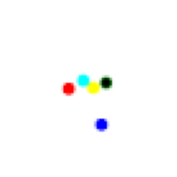

In [35]:
fig = plt.figure(figsize=(3,3))
plt.imshow(batch['s1']['xt'][batch_idx,t_idx].cpu().permute(1,2,0).numpy())
plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


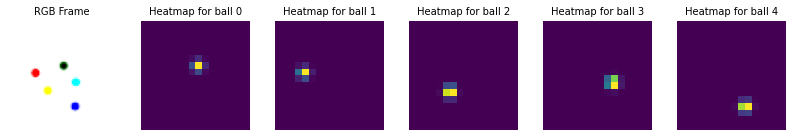

In [181]:
with PdfPages(figure_path + '/Ball_latents.pdf') as pdf:

    fig, axes = plt.subplots(1,6,figsize=(14,2))
    axes[0].imshow(batch['s1']['xt'][batch_idx,t_idx].cpu().permute(1,2,0).numpy())
    axes[0].set_title('RGB Frame', size=10)
    axes[0].axis('off')
    for obj_idx in range(5):
        axes[obj_idx+1].imshow(hmap[batch_idx,t_idx,obj_idx].detach().numpy())
        axes[obj_idx+1].set_title('Heatmap for ball %d'%obj_idx, size=10)
        axes[obj_idx+1].axis('off')
    pdf.savefig(fig, bbox_inches="tight")
# axes[1].imshow(x_recon[batch_idx][t_idx].detach().cpu().permute(1,2,0).numpy())

# plt.imshow(x_recon[0][0].detach().cpu().permute(1,2,0).numpy())

In [29]:
plt.imshow(hmap[batch_idx,t_idx,obj_idx].detach().numpy())

IndexError: index 5 is out of bounds for dimension 2 with size 5

In [47]:
zs[batch_idx, t_idx].reshape(5,4)

tensor([[-0.1700, -0.2793, -0.4884, -0.9389],
        [-0.4274,  0.4724,  0.9732,  0.0186],
        [-0.2260,  0.1595, -0.9908, -0.9801],
        [ 0.3080,  0.2105, -0.9216,  1.0161],
        [-0.1094,  0.2379,  0.9666, -0.9444]], grad_fn=<ViewBackward>)

In [48]:
batch['s1']['yt'][batch_idx, t_idx]

tensor([[ 0.6370, -0.0166,  0.0000,  0.0000],
        [-0.4168, -0.2252,  0.0000,  0.0000],
        [-0.1568,  0.2166,  0.0000,  0.0000],
        [ 0.3660, -0.7049,  0.0000,  0.0000],
        [ 0.4579,  0.7368,  0.0000,  0.0000]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 63.5, 63.5, -0.5)

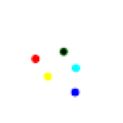

In [22]:
fig = plt.figure(figsize=(2,2))
plt.imshow(batch['s1']['xt'][batch_idx,t_idx].cpu().permute(1,2,0).numpy())
plt.axis('off')

In [ ]:
src_kp = zs.reshape(batch_size*length, self.n_kps, 2)
src_feat = feat.reshape(batch_size*length,feat.shape[2],feat.shape[3],feat.shape[4])
x_recon = self.kp.decode(src_feat, src_kp)

In [58]:
x_recon = model.dec(zs)
x_recon = x_recon.view(32, 6, 1, 16, 16)

In [84]:
zs[0,0]

tensor([  7.2390, -26.3971,  33.1765,   3.9791,  -7.4816, -11.1772],
       grad_fn=<SelectBackward>)